# NLP 2 : Neural Embeddings, Text Classification, Text Generation


To use statistical classifiers with text, it is first necessary to vectorize the text. In the first practical session we explored the **bag of word** model. 

Modern **state of the art** methods uses  embeddings to vectorize the text before classification in order to avoid feature engineering.

## Dataset
https://github.com/cedias/practicalNLP/tree/master/dataset

## "Modern" NLP pipeline

By opposition to the **bag of word** model, in the modern NLP pipeline everything is **embeddings**. Instead of encoding a text as a **sparse vector** of length $D$ (size of feature dictionnary) the goal is to encode the text in a meaningful dense vector of a small size $|e| <<< |D|$. 


The raw classification pipeline is then the following:

```
raw text ---|embedding table|-->  vectors --|Neural Net|--> class 
```


### Using a  language model:

How to tokenize the text and extract a feature dictionnary is still a manual task. To directly have meaningful embeddings, it is common to use a pre-trained language model such as `word2vec` which we explore in this practical.

In this setting, the pipeline becomes the following:
```
      
raw text ---|(pre-trained) Language Model|--> vectors --|classifier (or fine-tuning)|--> class 
```


- #### Classic word embeddings

 - [Word2Vec](https://arxiv.org/abs/1301.3781)
 - [Glove](https://nlp.stanford.edu/projects/glove/)


- #### bleeding edge language models techniques (only here for reference)

 - [UMLFIT](https://arxiv.org/abs/1801.06146)
 - [ELMO](https://arxiv.org/abs/1802.05365)
 - [GPT](https://blog.openai.com/language-unsupervised/)
 - [BERT](https://arxiv.org/abs/1810.04805)






### Goal of this session:

1. Train word embeddings on training dataset
2. Tinker with the learnt embeddings and see learnt relations
3. Tinker with pre-trained embeddings.
4. Use those embeddings for classification
5. Compare different embedding models
6. Pytorch first look: learn to generate text.





##  Loading data (same as in nlp 1)

In [1]:
import json
from collections import Counter

#### /!\ YOU NEED TO UNZIP dataset/json_pol.zip first /!\


# Loading json
with open("json_pol",encoding="utf-8") as f:
    data = f.readlines()
    json_data = json.loads(data[0])
    train = json_data["train"]
    test = json_data["test"]
    

# Quick Check
counter_train = Counter((x[1] for x in train))
counter_test = Counter((x[1] for x in test))
print("Number of train reviews : ", len(train))
print("----> # of positive : ", counter_train[1])
print("----> # of negative : ", counter_train[0])
print("")
print(train[0])
print("")
print("Number of test reviews : ",len(test))
print("----> # of positive : ", counter_test[1])
print("----> # of negative : ", counter_test[0])

print("")
print(test[0])
print("")



Number of train reviews :  25000
----> # of positive :  12500
----> # of negative :  12500

["The undoubted highlight of this movie is Peter O'Toole's performance. In turn wildly comical and terribly terribly tragic. Does anybody do it better than O'Toole? I don't think so. What a great face that man has!<br /><br />The story is an odd one and quite disturbing and emotionally intense in parts (especially toward the end) but it is also oddly touching and does succeed on many levels. However, I felt the film basically revolved around Peter O'Toole's luminous performance and I'm sure I wouldn't have enjoyed it even half as much if he hadn't been in it.", 1]

Number of test reviews :  25000
----> # of positive :  12500
----> # of negative :  12500

['Although credit should have been given to Dr. Seuess for stealing the story-line of "Horton Hatches The Egg", this was a fine film. It touched both the emotions and the intellect. Due especially to the incredible performance of seven year old 

## Word2Vec: Quick Recap

**[Word2Vec](https://arxiv.org/abs/1301.3781) is composed of two distinct language models (CBOW and SG), optimized to quickly learn word vectors**


given a random text: `i'm taking the dog out for a walk`



### (a) Continuous Bag of Word (CBOW)
    -  predicts a word given a context
    
maximizing `p(dog | i'm taking the ___ out for a walk)`
    
### (b) Skip-Gram (SG)               
    -  predicts a context given a word
    
 maximizing `p(i'm taking the out for a walk | dog)`



   

## Step 1: train (or load) a language model (word2vec)

Gensim has one of [Word2Vec](https://radimrehurek.com/gensim/models/word2vec.html) fastest implementation.


### Train:

In [3]:
import gensim
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

text = [t.split() for t,p in train]

# the following configuration is the default configuration
w2v = gensim.models.word2vec.Word2Vec(sentences=text,
                                vector_size=100, window=5,               ### here we train a cbow model 
                                min_count=5,                      
                                sample=0.001, workers=3,
                                sg=1, hs=0, negative=5,        ### set sg to 1 to train a sg model
                                cbow_mean=1,
                                epochs=5)

2022-02-17 14:08:54,863 : INFO : collecting all words and their counts
2022-02-17 14:08:54,864 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-02-17 14:08:55,118 : INFO : PROGRESS: at sentence #10000, processed 2358544 words, keeping 155393 word types
2022-02-17 14:08:55,384 : INFO : PROGRESS: at sentence #20000, processed 4675912 words, keeping 243050 word types
2022-02-17 14:08:55,523 : INFO : collected 280617 word types from a corpus of 5844680 raw words and 25000 sentences
2022-02-17 14:08:55,524 : INFO : Creating a fresh vocabulary
2022-02-17 14:08:55,675 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=5 retains 49345 unique words (17.584465659600095%% of original 280617, drops 231272)', 'datetime': '2022-02-17T14:08:55.674872', 'gensim': '4.1.2', 'python': '3.7.3 (default, Dec 20 2019, 18:57:59) \n[GCC 8.3.0]', 'platform': 'Linux-4.19.0-9-amd64-x86_64-with-debian-10.4', 'event': 'prepare_vocab'}
2022-02-17 14:08:55,675 : INFO : Word2

2022-02-17 14:09:33,738 : INFO : EPOCH 5 - PROGRESS: at 93.38% examples, 565429 words/s, in_qsize 5, out_qsize 0
2022-02-17 14:09:34,212 : INFO : worker thread finished; awaiting finish of 2 more threads
2022-02-17 14:09:34,219 : INFO : worker thread finished; awaiting finish of 1 more threads
2022-02-17 14:09:34,220 : INFO : worker thread finished; awaiting finish of 0 more threads
2022-02-17 14:09:34,221 : INFO : EPOCH - 5 : training on 5844680 raw words (4268649 effective words) took 7.5s, 565967 effective words/s
2022-02-17 14:09:34,221 : INFO : Word2Vec lifecycle event {'msg': 'training on 29223400 raw words (21340905 effective words) took 38.0s, 561209 effective words/s', 'datetime': '2022-02-17T14:09:34.221506', 'gensim': '4.1.2', 'python': '3.7.3 (default, Dec 20 2019, 18:57:59) \n[GCC 8.3.0]', 'platform': 'Linux-4.19.0-9-amd64-x86_64-with-debian-10.4', 'event': 'train'}
2022-02-17 14:09:34,221 : INFO : Word2Vec lifecycle event {'params': 'Word2Vec(vocab=49345, vector_size=100,

### Load pre-trained embeddings:

In [4]:
# It's for later

#from gensim.test.utils import datapath
#w2v = KeyedVectors.load_word2vec_format(datapath('downloaded_vectors_path'), binary=False)  

In Gensim, embeddings are loaded and can be used via the ["KeyedVectors"](https://radimrehurek.com/gensim/models/keyedvectors.html) class

> Since trained word vectors are independent from the way they were trained (Word2Vec, FastText, WordRank, VarEmbed etc), they can be represented by a standalone structure, as implemented in this module.

>The structure is called “KeyedVectors” and is essentially a mapping between entities and vectors. Each entity is identified by its string id, so this is a mapping between {str => 1D numpy array}.

>The entity typically corresponds to a word (so the mapping maps words to 1D vectors), but for some models, they key can also correspond to a document, a graph node etc. To generalize over different use-cases, this module calls the keys entities. Each entity is always represented by its string id, no matter whether the entity is a word, a document or a graph node.

## STEP 2: Test learnt embeddings

The word embedding space directly encodes similarities between words: the vector coding for the word "great" will be closer to the vector coding for "good" than to the one coding for "bad". Generally, [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity) is the distance used when considering distance between vectors.

KeyedVectors have a built in [similarity](https://radimrehurek.com/gensim/models /keyedvectors.html#gensim.models.keyedvectors.BaseKeyedVectors.similarity) method to compute the cosine similarity between words

In [37]:
# is great really closer to good than to bad ?
print("great and good:",w2v.wv.similarity("great","good"))
print("great and bad:",w2v.wv.similarity("great","bad"))

great and good: 0.7703075
great and bad: 0.5083331


Since cosine distance encodes similarity, neighboring words are supposed to be similar. The [most_similar](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.BaseKeyedVectors.most_similar) method returns the `topn` words given a query.

In [38]:
# The query can be as simple as a word, such as "movie"

# Try changing the word
w2v.wv.most_similar("movie",topn=5) # 5 most similar words
#w2v.wv.most_similar("awesome",topn=5)
#w2v.wv.most_similar("actor",topn=5)

[('film', 0.9380859136581421),
 ('"film"', 0.8366387486457825),
 ('"movie"', 0.8037150502204895),
 ('movie,', 0.7774391174316406),
 ('flick', 0.7754345536231995)]

But it can be a more complicated query
Word embedding spaces tend to encode much more.

The most famous exemple is: `vec(king) - vec(man) + vec(woman) => vec(queen)`

In [39]:
# What is awesome - good + bad ?
w2v.wv.most_similar(positive=["awesome","bad"],negative=["good"],topn=3)  

#w2v.wv.most_similar(positive=["actor","woman"],negative=["man"],topn=3) # do the famous exemple works for actor ?


# Try other things like plurals for exemple.


[('awful', 0.7360645532608032),
 ('crappy', 0.64714515209198),
 ('abysmal', 0.6406511664390564)]

To test learnt "synctactic" and "semantic" similarities, Mikolov et al. introduced a special dataset containing a wide variety of three way similarities.

In [28]:
out = w2v.wv.evaluate_word_analogies("questions-words.txt",case_insensitive=True)  #original semantic syntactic dataset.

2022-02-17 14:24:39,978 : INFO : Evaluating word analogies for top 300000 words in the model on questions-words.txt
2022-02-17 14:24:40,196 : INFO : capital-common-countries: 1.3% (2/156)
2022-02-17 14:24:40,371 : INFO : capital-world: 1.8% (2/111)
2022-02-17 14:24:40,423 : INFO : currency: 0.0% (0/18)
2022-02-17 14:24:40,819 : INFO : city-in-state: 0.0% (0/301)
2022-02-17 14:24:41,409 : INFO : family: 32.4% (136/420)
2022-02-17 14:24:42,557 : INFO : gram1-adjective-to-adverb: 2.1% (18/870)
2022-02-17 14:24:43,209 : INFO : gram2-opposite: 2.4% (13/552)
2022-02-17 14:24:44,608 : INFO : gram3-comparative: 18.2% (216/1190)
2022-02-17 14:24:45,497 : INFO : gram4-superlative: 9.9% (75/756)
2022-02-17 14:24:46,459 : INFO : gram5-present-participle: 20.1% (163/812)
2022-02-17 14:24:47,545 : INFO : gram6-nationality-adjective: 1.4% (14/967)
2022-02-17 14:24:49,053 : INFO : gram7-past-tense: 21.3% (268/1260)
2022-02-17 14:24:50,047 : INFO : gram8-plural: 7.1% (58/812)
2022-02-17 14:24:50,820 : 

When training the w2v models on the review dataset, since it hasn't been learnt with a lot of data, it does not perform very well. 


## STEP 3:  sentiment classification

In the previous practical session, we used a bag of word approach to transform text into vectors.
Here, we propose to try to use word vectors (previously learnt or loaded).


### <font color='green'> Since we have only word vectors and that sentences are made of multiple words, we need to aggregate them. </font>


### (1) Vectorize reviews using word vectors:

Word aggregation can be done in different ways:

- Sum
- Average
- Min/feature
- Max/feature

#### a few pointers:

- `w2v.wv.vocab` is a `set()` of the vocabulary (all existing words in your model)
- `np.minimum(a,b) and np.maximum(a,b)` respectively return element-wise min/max 

In [57]:
import numpy as np
# We first need to vectorize text:
# First we propose to a sum of them


def vectorize(text,mean=False):
    """
This function should vectorize one review

input: str
output: np.array(float)
""" 
    out = np.zeros(w2v.wv.vector_size)
    words = text.split()

    for word in words:
        if word in w2v.wv.key_to_index:
            out += w2v.wv.get_vector(word)
    
    if mean:
        out = out /len(out) 
    
    return np.array(out)




classes = [pol for text,pol in train]
X = [vectorize(text) for text,pol in train]
print(X[0])
X_test = [vectorize(text) for text,pol in test]
true = [pol for text,pol in test]

#let's see what a review vector looks like.
print(X[0])

[-1.60161260e+00  2.34261493e+01  2.85458832e+00 -4.02416524e-01
 -3.84110824e-01 -1.50540183e+01  1.26395273e+01  2.93201242e+01
 -3.18219926e+01 -1.93918301e+01  3.04965462e+00 -1.91284421e+01
  1.80939776e+00  7.68914065e+00  3.92100169e+00 -1.39483021e+01
  7.95380589e+00 -1.02666420e+01 -4.50450445e+00 -5.08434701e+01
  1.12570424e+01  9.51207362e+00  1.42607800e+01 -1.59116835e+01
  2.92106551e+00 -9.11876570e+00 -1.58846393e+01  1.11142396e+00
 -1.47880175e+01  1.48105596e+01  3.45700143e+01 -1.11219331e+01
  1.41847650e+01 -1.98434904e+01 -8.46705215e+00  1.12777096e+01
 -8.24183159e-01  1.12461092e+01 -9.12432173e+00 -1.47258999e+01
  1.99210619e+01 -1.45931017e+01 -1.08363237e+01 -1.57887857e-01
  1.76077756e+01  6.97343782e+00 -1.54449440e+01 -5.74768056e+00
  1.96426683e+01  9.89441384e+00  7.35843183e+00 -2.61774646e+01
  3.84610711e+00 -2.16774679e+00 -1.08373068e+01  1.45704646e+01
  1.45386306e+01  4.16796077e+00 -1.97490049e+01  2.92674820e+00
  9.02114664e+00 -4.24425

### (2) Train a classifier 
as in the previous practical session, train a logistic regression to do sentiment classification with word vectors



In [54]:
print(X[-10:])

[array([-4.34236219e+00,  3.62662455e+01,  4.14375157e+00, -4.22486309e+00,
        7.82260588e-01, -3.00393723e+01,  2.00649612e+01,  5.78603410e+01,
       -5.87014027e+01, -3.62172614e+01,  3.88868139e+00, -2.26265997e+01,
       -5.95832126e+00,  1.25780692e+01,  8.89782955e-01, -1.50965601e+01,
        5.08506664e+00, -2.05852479e+01, -1.18229582e+01, -8.32876473e+01,
        9.37544894e+00,  1.40406474e+01,  2.79653832e+01, -3.40109885e+01,
        8.11723651e-02, -7.39161443e+00, -3.50620998e+01, -8.86587314e-01,
       -2.12490439e+01,  2.64194772e+01,  5.10030558e+01, -1.92979023e+01,
        2.82766312e+01, -2.04660170e+01, -1.90326637e+01,  2.45674130e+01,
       -5.28498378e+00,  2.06663259e+01, -2.33218443e+01, -2.55065903e+01,
        3.45070483e+01, -1.30247758e+01, -2.07453915e+01,  7.27442256e-02,
        3.69683459e+01,  1.10841353e+01, -1.59619751e+01, -1.51544273e+01,
        4.66436658e+01,  1.98787002e+01,  9.25008722e+00, -4.43417702e+01,
        7.49701840e+00, 

In [59]:

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import normalize


# Scikit Logistic Regression
model_log = LogisticRegression(random_state=0,solver='liblinear')
model_log.fit(X, classes)

pred_model = model_log.predict(X_test)
print(" Regression accuracy with sum: ",accuracy_score(true, pred_model))
X_mean = [vectorize(text,True) for text,pol in train]

X_test_mean = [vectorize(text,True) for text,pol in test]


model_log_mean =  LogisticRegression(random_state=0,solver='liblinear')
model_log_mean.fit(X_mean, classes)
pred_model_mean = model_log.predict(X_test_mean)
print(" Regression accuracy with mean: ",accuracy_score(true, pred_model_mean))

 Regression accuracy with sum:  0.82112
 Regression accuracy with mean:  0.82044


performance should be worst than with bag of word (~80%). Sum/Mean aggregation does not work well on long reviews (especially with many frequent words). This adds a lot of noise.

## **Todo** :  Try answering the following questions:

- Which word2vec model works best: skip-gram or cbow
- Do pretrained vectors work best than those learnt on the train dataset ?



**(Bonus)** To have a better accuracy, we could try two things:
- Better aggregation methods (weight by tf-idf ?)
- Another word vectorizing method such as [fasttext](https://radimrehurek.com/gensim/models/fasttext.html)
- A document vectorizing method such as [Doc2Vec](https://radimrehurek.com/gensim/models/doc2vec.html)

## --- Generate text with a recurrent neural network (Pytorch) ---
### (Mostly Read & Run)

The goal is to replicate the (famous) experiment from [Karpathy's blog](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)

To learn to generate text, we train a recurrent neural network to do the following task:

Given a "chunk" of text: `this is random text`

the goal of the network is to predict each character in **`his is random text` ** sequentially given the following sequential input **`this is random tex`**:




## Load text (dataset/input.txt)

Before building training batch, we load the full text in RAM

In [61]:
pip install Unidecode

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.7/235.7 KB 15.7 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Note: you may need to restart the kernel to use updated packages.


In [63]:
import unidecode
import string
import random
import re
import torch
import torch.nn as nn

all_characters = string.printable
n_characters = len(all_characters)

file = unidecode.unidecode(open('input.txt').read()) #clean text => only ascii
file_len = len(file)
print('file_len =', file_len)


file_len = 1115394


## 2: Helper functions:

We have a text and we want to feed batch of chunks to a neural network:

one chunk  A,B,C,D,E
[input] A,B,C,D -> B,C,D,E [output]

Note: we will use an embedding layer instead of a one-hot encoding scheme.

for this, we have 3 functions:

- One to get a random str chunk of size `chunk_len` : `random_chunk` 
- One to turn a chunk into a tensor of size `(1,chunk_len)` coding for each characters : `char_tensor`
- One to return random input and output chunks of size `(batch_size,chunk_len)` : `random_training_set`




In [64]:
import time, math


#Get a piece of text
def random_chunk(chunk_len):
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]


# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(1,len(string)).long()
    for c in range(len(string)):
        tensor[0,c] = all_characters.index(string[c])
    return tensor


#Turn a piece of text in train/test
def random_training_set(chunk_len=200, batch_size=8):
    chunks = [random_chunk(chunk_len) for _ in range(batch_size)]
    inp = torch.cat([char_tensor(chunk[:-1]) for chunk in chunks],dim=0)
    target = torch.cat([char_tensor(chunk[1:]) for chunk in chunks],dim=0)
    
    return inp, target

print(random_training_set(10,4))  ## should return 8 chunks of 10 letters. 

(tensor([[32, 28, 94, 17, 14, 94, 18, 28, 82, 96],
        [23, 29, 77, 94, 18, 15, 94, 34, 24, 30],
        [77, 96, 50, 73, 94, 16, 18, 31, 14, 94],
        [14, 27, 15, 30, 21, 75, 96, 96, 42, 47]]), tensor([[28, 94, 17, 14, 94, 18, 28, 82, 96, 96],
        [29, 77, 94, 18, 15, 94, 34, 24, 30, 94],
        [96, 50, 73, 94, 16, 18, 31, 14, 94, 22],
        [27, 15, 30, 21, 75, 96, 96, 42, 47, 50]]))


## The actual RNN model (only thing to complete):

It should be composed of three distinct modules:

- an [embedding layer](https://pytorch.org/docs/stable/nn.html#embedding) (n_characters, hidden_size)

```
nn.Embedding(len_dic,size_vec)
```
- a [recurrent](https://pytorch.org/docs/stable/nn.html#recurrent-layers) layer (hidden_size, hidden_size)
```
nn.RNN(in_size,out_size) or nn.GRU() or nn.LSTM() => rnn_cell parameter
```
- a [prediction](https://pytorch.org/docs/stable/nn.html#linear) layer (hidden_size, output_size)

```
nn.Linear(in_size,out_size)
```
=> Complete the `init` function code

In [65]:
import torch.nn.functional as f

class RNN(nn.Module):
    
    def __init__(self, n_char, hidden_size, output_size, n_layers=1,rnn_cell=nn.RNN):
        """
        Create the network
        """
        super(RNN, self).__init__()
        
        self.n_char = n_char
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        #  (batch,chunk_len) -> (batch, chunk_len, hidden_size)  
        self.embed = nn.Embedding(n_char,hidden_size)
        
        # (batch, chunk_len, hidden_size)  -> (batch, chunk_len, hidden_size)  
        self.rnn = rnn_cell(hidden_size,hidden_size)
        
        #(batch, chunk_len, hidden_size) -> (batch, chunk_len, output_size)  
        self.predict = nn.Linear(hidden_size,output_size)
    
    def forward(self, input):
        """
        batched forward: input is (batch > 1,chunk_len)
        """
        input = self.embed(input)
        output,_  = self.rnn(input)
        output = self.predict(f.tanh(output))
        return output
    
    def forward_seq(self, input,hidden=None):
        """
        not batched forward: input is  (1,chunk_len)
        """
        input = self.embed(input)
        output,hidden  = self.rnn(input.unsqueeze(0),hidden)
        output = self.predict(f.tanh(output))
        return output,hidden




## Text generation function

Sample text from the model

In [66]:
def generate(model,prime_str='A', predict_len=100, temperature=0.8):
    prime_input = char_tensor(prime_str).squeeze(0)
    hidden = None
    predicted = prime_str+""
    # Use priming string to "build up" hidden state

    for p in range(len(prime_str)-1):
        _,hidden = model.forward_seq(prime_input[p].unsqueeze(0),hidden)
            
    #print(hidden.size())
    for p in range(predict_len):
        output, hidden = model.forward_seq(prime_input[-1].unsqueeze(0), hidden)
                # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        #print(output_dist)
        top_i = torch.multinomial(output_dist, 1)[0]
        #print(top_i)
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        prime_input = torch.cat([prime_input,char_tensor(predicted_char).squeeze(0)])

    return predicted



## Training loop for net

In [67]:
def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

###Parameters
n_epochs = 20000
print_every = 100
plot_every = 10
hidden_size = 100
n_layers = 5
lr = 0.005
batch_size = 16
chunk_len = 80

####

model = RNN(n_characters, hidden_size, n_characters, n_layers) #create model
model_optimizer = torch.optim.Adam(model.parameters(), lr=lr) #create Adam optimizer
criterion = nn.CrossEntropyLoss() #chose criterion

start = time.time()
all_losses = []
loss_avg = 0


def train(inp, target):
    """
    Train sequence for one chunk:
    """
    #reset gradients
    model_optimizer.zero_grad() 
    
    # predict output
    output = model(inp)
    
    #compute loss
    loss =  criterion(output.view(batch_size*chunk_len,-1), target.view(-1)) 

    #compute gradients and backpropagate
    loss.backward() 
    model_optimizer.step() 

    return loss.data.item() 



for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set(chunk_len,batch_size))  #train on one chunk 
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(generate(model,'Wh', 100), '\n')
       


    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 2s (100 0%) 2.5365]
Whtere, INThe, be than f here, m f cest is inotht ed I my there fr thal are y.
Shea whlis bories hef w 

 3s (200 1%) 2.5097]
Whivey kerlit cke f s owilousive m athal cend mef tes outh wio my whane le, sthathan t ounge winan yon 

 4s (300 1%) 2.5139]
Whthe for hew tre ie je hichest, w f I thater d hinlend t hourow d t carthe burd yod har wowito frimyo 

 5s (400 2%) 2.4861]
Wheng.
Whand bow
Why y bou,
I k t bel wanifoulve this vest wasthathence d ie n d tere he omille an hit 

 6s (500 2%) 2.4811]
Wh If whth ithay g wer qucusl and t in r, ss torenencod chousthee t mose t.
WINUNENG besoresp sio hith 

 7s (600 3%) 2.4930]
Wh, mere hathele ne Houmy fazeeve t wome at
Fis tere iso te t,
Thaisofall in
The y wlis; t,
Hat ard,
H 

 8s (700 3%) 2.4391]
Whourses, w wick windamowe CIZAnd is ass o,
Nofrs fos hepeanotrd inl the thengh andothe ghut g ns fofa 

 9s (800 4%) 2.4792]
Whe gour e cour.

QUS:
LI:
T:
To t
The KEO:
Therid sty
Nos ge-t TUS:
The meshinere g rs wedon's V

 10s (6400 32%) 2.4816]
Whithis lo.
Anere it qukeerelusus t nd antullll tr tom.
ONI d pr to at ar's ty I s f ccorand ay w ind. 

 11s (6500 32%) 2.5104]
Whaswan beat ache ass ma soochisei'd rd an pe!
' it t in ollour t than ce bullolf thind, d, Pr, wind t 

 12s (6600 33%) 2.4447]
Whe we nd I unche IORELAn 'shrea gheroul as ur IIf MInd y spr IETh mur sthicer se il d s andond.
TENGH 

 13s (6700 33%) 2.4809]
Whandomat's belouthid wieey son ry;
Murtou we he pe:
I sole ie kico bobl.
Be t cay ghe WIUSTholouram a 

 14s (6800 34%) 2.4757]
Whe athises t mmy our winge le;
To CO'l de, myo ond seser andernd,




Buas h, s mouse g t se gherouth 

 15s (6900 34%) 2.4084]
Whean IIUCoun ausind, ngho,

USININe bus ingr bulysidrkiso andstellorareliouthorithe hurechanthenghes  

 16s (7000 35%) 2.4664]
Whid hes t I the f ie t th RINICESCEORo fay ands ou hithe t n t I'l nder hare ines iawitloue tthou,
I  

 17s (7100 35%) 2.4139]
Whaspourayod nddr il ncerd thid crore ous d se in onelld hutesor hathame 

 16s (12600 63%) 2.4697]
Whe t he fothe ffe ace of y ayongnd mearthe me ke allo has I trepowefr br te be cis thes, calld serth  

 17s (12700 63%) 2.5008]
Whed nceliknd he his bom ben s w, here thed dd f ld hatou e ckne melim:
Bupl t s tourelatye
KI whis, m 

 18s (12800 64%) 2.4889]
Whine thatondere oune o simow'd, p ceer.
Win, silduchokispu helild, t ck atidinothiruclorsprn Silyo'd  

 19s (12900 64%) 2.4542]
Who t gr, impouringe per peend ansind the is fonthif at t g
Alily d INGof bisit tere wil ave
Y o aind  

 20s (13000 65%) 2.4331]
Whe sitheararishe dy bences m ore-th;
ANGLendor blesange oime s yollserit
Whe tod llllearayord por ld  

 21s (13100 65%) 2.4455]
Whal t s in:
PAnd ierdst t e ss ERD erilve bll py,
Mye g d.
NGLULLAnthat d t?
AS:
CHes,
IUCoe.
Frseve  

 22s (13200 66%) 2.4576]
Whe?
Weshendo at ke had ase arame thathuthelero th m RKE ale is beayot ais I s mene he hise mmy t:
TOr 

 23s (13300 66%) 2.4941]
Wherd s. ive ppind thothen an sthand LOM:
ARIULe ar ncere bave t 

 21s (18800 94%) 2.4169]
Whe kinad wing lerintoueind wiseave therd anourd he herng,
Hesthe. wn weis wiss t t, m br w hal'?
Tour 

 22s (18900 94%) 2.4398]
When mowou thand,
Wesurd at e Bu atos ffeinell ourerswoutes athes
Ay, thand hit.
Anco n r an r, t gha  

 23s (19000 95%) 2.5367]
Whed ore t d pre th, st whaccllld cond hinerond:
Thareswoan, n:
IULI we thathire ere, alld s he he g d 

 24s (19100 95%) 2.4974]
Whithis oo mathave meat my, s r t hourcor thar ld th t h, t wo, ant ardecoure, m n thar seaye be sth:
 

 25s (19200 96%) 2.4819]
Who fof senthe; mon ncof he.
Pakimeued fathod keromy al Gl eeathecheren ithis the pre ome ES:
CERedera 

 27s (19300 96%) 2.4883]
Whes heinoun hord bure serom an antishicomas's be hint he, boue theave,

AN s isthom t

ARUCENICHe S:
 

 28s (19400 97%) 2.4590]
Whond at ms, t t wed angnd; h.
Pown y t cand pthind ghe art RET:
Fase my;
Hare tomet d th, h ng I he t 

 29s (19500 97%) 2.4392]
Whe pls yer:
TENNANThend, ghe o t avethin he, f tofe thablloulan:

## Visualize loss 

2022-02-17 15:58:03,888 : INFO : Failed to extract font properties from /usr/share/fonts/truetype/noto/NotoColorEmoji.ttf: In FT2Font: Can not load face.  Unknown file format.
2022-02-17 15:58:04,664 : INFO : generated new fontManager


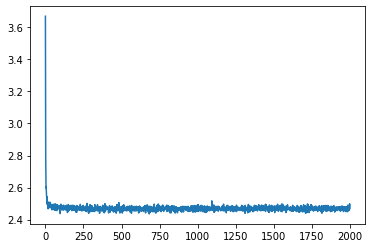

In [69]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

## Try different temperatures

Changing the distribution sharpness has an impact on character sampling:

more or less probable things are sampled

In [68]:
print(generate(model,'T', 200, temperature=1))
print("----")
print(generate(model,'Th', 200, temperature=0.8))
print("----")

print(generate(model,'Th', 200, temperature=0.5))
print("----")

print(generate(model,'Th', 200, temperature=0.3))
print("----")

print(generate(model,'Th', 200, temperature=0.1))

THears ORo
A:
LOM:


V:
HULINAn t d fearer terse, NTy on ameariolisitoo al y aies bitte hsptoristo acoora-


Be ast s betour scuized e touis hau e qustecerat ceanon y IOFof felamen'lld, thaitharvar my 
----
Tho beathe y, bulomefagu ace har wis!'t d ff ane the hathare o t we nouromonn, mpe etus heake me hesth s toungant herdid hangro is te y

CA:
Whe thale ho
BEThiped withalil; s thert by t tr the ar an, th
----
Ther f ne fo the n:

Anoun the hint hand wis r t:
And thtit s s s aiste the he the d mowhavar the the lathendy o tha be sthe s ththe s s win the the t it s me t me t the ge t atr an, my ousthend aind t 
----
The thanour t an t he tin the t m thar the n the s s me the the he mand I the wis t the t the t s s the mer man t s wind s the s the the at s s the t ind d the st the be the ne t be s s winou me at the 
----
The the the t the the t the the t the the the the the the the the the the t t the the the the t than the the the the the t the the the the t the the the the the the the 

### Improving this code:

(a) Tinker with parameters:

- Is it really necessary to have 100 dims character embeddings
- Chunk length can be gradually increased
- Try changing RNN cell type (GRUs - LSTMs)

(b) Add GPU support to go faster


## ------ End of practical

#### Legacy loading code

In [ ]:
import glob
from os.path import split as pathsplit

dir_train = "aclImdb/train/"
dir_test = "aclImdb/test/"

train_files = glob.glob(dir_train+'pos/*.txt') + glob.glob(dir_train+'neg/*.txt')
test_files = glob.glob(dir_test+'pos/*.txt') + glob.glob(dir_test+'neg/*.txt')


def get_polarity(f):
    """
    Extracts polarity from filename:
    0 is negative (< 5)
    1 is positive (> 5)
    """
    _,name = pathsplit(f)
    if int(name.split('_')[1].split('.')[0]) < 5:
        return 0
    else:
        return 1


def open_one(f):
    
    polarity = get_polarity(f)
    
    with open(f,"r") as review:
        text = " ".join(review.readlines()).strip()
    
    return (text,polarity)

print(open_one(train_files[0]))

train = [open_one(x) for x in train_files] #contains (text,pol) couples
test = [open_one(x) for x in test_files]   #contains (text,pol) couples
